```{margin} Adaptation!
This lecture was also adapted from lecture notes in John Kitchin's excellent 06-623 course. His lecture notes are included in the helpful resources link if you want to know more details about how numerical methods work. These notes also contain content from Prof. Ulissi's 06-262 course. 
```

# Local Optimization and Curve Fitting


`````{note}
This lecture is going to:
* Quickly review why we care about finding minima and maxima of functions
* Demonstrate three methods for finding minima/maxima:
    * Evaluate the function at a bunch of points and find the minimum one
    * Using a non-linear solver to find where the gradient is zero
    * Using a local optimizer from scipy
* Demonstrate but not discuss in detail global
* Show that finding minima and maxima are the same problem

After covering these ideas, we will practice on a problem that we can also solve with ODE events!

`````

## Function extrema

It is pretty common to need to find extreme values of a function in engineering analysis. An extreme value is often a maximum or minimum in a function, and we seek them when we want to maximize a profit function, or minimize a cost function, identify a maximum safe operating condition, etc.

Let's consider an example function with a graphical solution approach. We want a quantitative estimate of the minimum in this function.

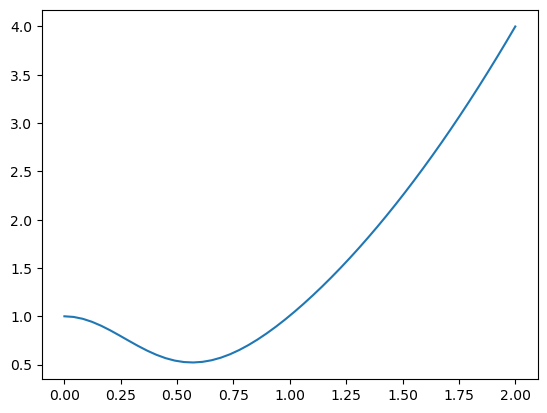

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def f(x):
    return x**2 + np.exp(-5 * x**2)


x = np.linspace(0, 2)
y = f(x)
plt.plot(x, y)

You can see there is a minimum near 0.6. We can find the minimum in a crude kind of way by finding the index of the minimum value in the y-array, and then getting the corresponding value of the x-array. You control the accuracy of this answer by the number of points you discretize the function over.

In [2]:
x = np.linspace(0, 2, 50)
y = f(x)
i = np.argmin(y)
x[i]

0.5714285714285714

`````{tip}

**Pros/cons of finding minima/maxima by inspection!**

Pros:
1.  It is easy.
2.  You *see* the whole domain you are looking at, and it is easy to see how many extrema their are

Cons:
1.  *Lot's* of function evaluations. Imagine if it took a long time to compute each value.
2.  Somewhat tedious.
3.  Not so easy to reproduce
4.  Not scalable to large problems, your time to do this becomes a limiting factor.
`````

### Find the derivative, and solve for where it is zero

We can also derive the first derivative:

$y' = 2x + e^{-5 x^2} (-10x)$

and solve it for zero using fsolve.

In [3]:
def yp(x):
    return 2 * x + np.exp(-5 * x**2) * (-10 * x)


from scipy.optimize import fsolve

fsolve(yp, 0.5)

array([0.56735137])

These two answer agree to 5 decimal places.

This depends on your ability to correctly derive and implement the derivative. It is good to know you can solve this problem by more than one method. Here, we use a numerical derivative in the function instead to check our derivative. You can check the convergence of the derivative by varying the dx.

In [4]:
from scipy.misc import derivative


def ypd(x):
    return derivative(f, x, dx=1e-6)


fsolve(ypd, 0.5)

array([0.56735137])

These look the same within tolerance. This is not a beautiful solution, but it is hard to argue with success here!

`````{tip}

**Pros/cons of finding minima/maxima by root finding of the derivatives!**

Pros:
1.  We've turned a new problem into a different numerical problem that might be easier to solve

Cons:
1.  You have to do a derivative by hand or use a numerical estimate.
2.  You get minima, maxima, and saddle points.
`````

### Standard python approach: scipy.optimize.minimize

Here is the basic use of scipy.optimize.minimize. As always, we should plot the answer where feasible to make sure it is the minimum we wanted.

`````{seealso}
Full documentation and notes on types of algorithms: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

More notes on various optimization techniques implemented in scipy: https://docs.scipy.org/doc/scipy/tutorial/optimize.html#optimization-scipy-optimize

`````

In [5]:
from scipy.optimize import minimize


def f(x):
    return x**2 + np.exp(-5 * x**2)


guess = 0.5
sol = minimize(f, guess)
sol

      fun: 0.5218875824868201
 hess_inv: array([[0.15524504]])
      jac: array([4.47034836e-08])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.56735137])

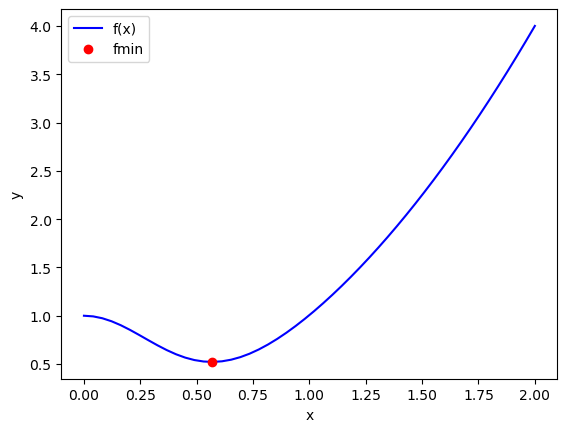

In [6]:
x = np.linspace(0, 2)
y = f(x)

plt.plot(x, y, "b-")
plt.plot(sol.x, f(sol.x), "ro")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["f(x)", "fmin"])

Note this answer is only the same in the first 4 decimal places. Remember that these iterative approaches stop when a tolerance is met. Check the defaults on fmin!

### Multiple minima

It is possible for functions to have more than one minimum. In this case, your guess will determine which minimum is found. Here is an example where there is a minimum near 2.2, and one near 4.5.

Text(0, 0.5, 'h(x)')

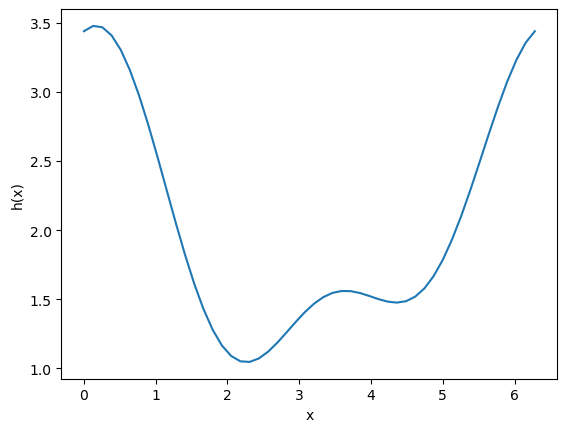

In [7]:
def h(x):
    return 2 + np.cos(x) + np.cos(2 * x - 0.5) / 2


x = np.linspace(0, 2 * np.pi)

plt.plot(x, h(x))
plt.xlabel("x")
plt.ylabel("h(x)")

This guess finds the one near 2.2:

In [8]:
minimize(h, 2)

      fun: 1.044887178374669
 hess_inv: array([[0.52337763]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([2.26106176])

and this guess finds the one near 4.5

In [9]:
minimize(h, 4)

      fun: 1.4758979742813338
 hess_inv: array([[0.94727416]])
      jac: array([-9.08970833e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([4.35545601])

You have to decide which one is better for the problem at hand. If this were a cost function, the one at the lower cost is probably better! Note that all we can say here is which one is lower in the interval we are looking at. By inspection of the function, you can see it will be periodic, so there will be many other minima that also exist.


`````{seealso}

Questions about local vs global minima and their use in decision making for engineering can be very interesting. You will discuss this in much more detail in your second mini (optimization) this semester!
`````

## Animation of minima finding

Just like in {doc}`review_odes`, we can visualize the points that are being sampled by the numerical method to find the local minimum. First, we'll make a quick wrapper function to save the function evaluations during the minimization.

In [10]:
def wrap_function_save_eval(x, function, function_eval_save):
    y = function(x)
    function_eval_save.append((x, y))
    return y


# List to contain all of the function evaluations
function_eval_save = []
x0 = 1

sol = minimize(wrap_function_save_eval, x0, args=(h, function_eval_save))

Now, we'll use the saved points to make a quick animation of the solution process.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

# Add the analytical solution
x = np.linspace(0, 2 * np.pi)
ax.plot(x, h(x))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([-1, 7])
ax.set_ylim([0, 4])

# Make a blank line and quiver to hold the data points as they get evaluated
(line,) = ax.plot([], [], "or", label="Function evaluations")
(linefinal,) = ax.plot([], [], "ok", label="Latest function evaluation")

ax.legend()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    linefinal.set_data([], [])

    return (line, linefinal)


# animation function. This is called sequentially
def animate(i):
    # unzip the t, y, and yp vectors as separate vectors
    x, y = zip(*function_eval_save)

    # Set the data for the line
    line.set_data(x[:i], y[:i])
    linefinal.set_data(x[i - 1], y[i - 1])

    return (line, linefinal)


# Make the animation!
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(function_eval_save) + 1,
    interval=1000,
    repeat_delay=5000,
    blit=True,
)

# Note: below is the part which helps it work on jupyterbook
rc("animation", html="jshtml")
anim

### Finding maxima

`minimize` is for finding *minima* (no surprise!). We can use it to find maxima though, by finding the *minima* of $-f(x)$. You can see here that when we plot $-h(x)$ the minima become maxima, and vice-versa. Now you can see there are two definite minima, one near zero, and one near 3.5, which correspond to the maxima of $h(x)$.

Text(0, 0.5, '-h(x)')

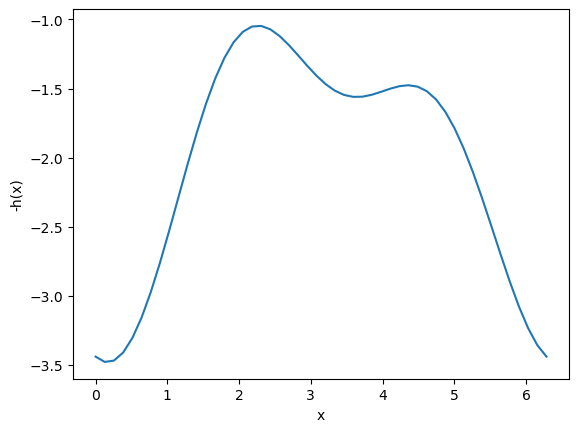

In [12]:
plt.plot(x, -h(x))
plt.xlabel("x")
plt.ylabel("-h(x)")

The standard way to use minimize is to define an optional argument for the sign that defaults to one. Then, when we call fmin, we will pass -1 as the sign to the function, so we find the minimum of -h(x). Then, we evaluate h(x) at that x-value to get the actual value of the maximum. It is not necessary do this, you can also manually pass around the sign and try to keep it straight.

Here is an example to find the maximum near 3.5.

[1.56120872]


Text(0, 0.5, 'h(x)')

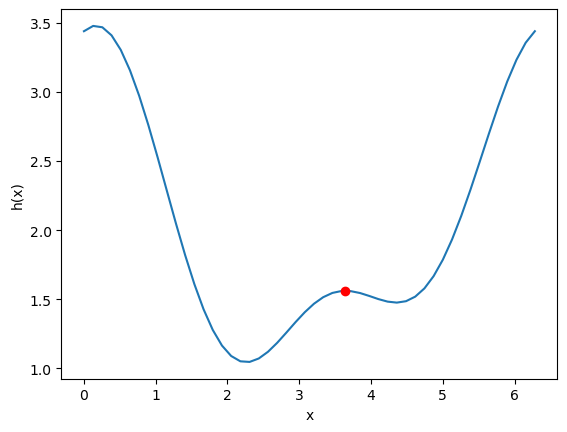

In [13]:
def h(x, sign=1):
    return sign * (2 + np.cos(x) + np.cos(2 * x - 0.5) / 2)


sol = minimize(h, 3.5, args=(-1,))  # set sign=-1 here to minimize -h(x)
print(h(sol.x))  # sign defaults to 1 here, so we get the maximum value

plt.plot(x, h(x))
plt.plot(sol.x, h(sol.x), "ro")
plt.xlabel("x")
plt.ylabel("h(x)")

Once again, here you have to decide which maximum is relevant

# Practice with functions of multiple variables

As practice, find the lowest of the local minima for the function $(x^2+y-11)^2+(x+y^2-7)^2$ in the domain  $x\in[-5,5],y\in[-5,5]$, visualized below!

`````{tip}
`minimize` can work with functions of multiple variables. Just like `solve_ivp`! It will expect a function with a vector input. You can unpack and use the variables with similar code like:
```
def f(X):
    x, y = X
    return x + y
    
minimize(f, [x0, y0])
```
`````

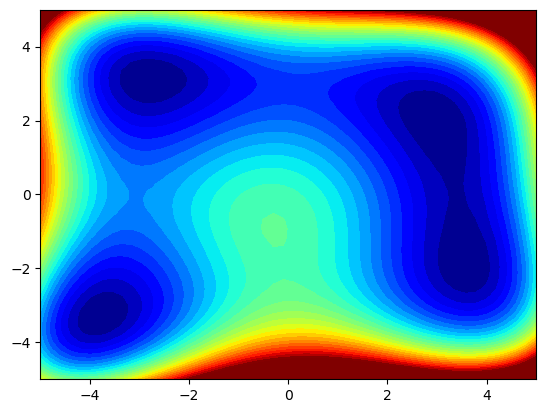

In [14]:
# Set limits for x/y
xrange = np.linspace(-5, 5)
yrange = np.linspace(-5, 5)

# Make 2d arrays for all the unique values of x/y
xgrid, ygrid = np.meshgrid(xrange, yrange)

# Generate the plot ofthe
zgrid = (xgrid**2 + ygrid - 11) ** 2 + (xgrid + ygrid**2 - 7) ** 2

# Plot the function as a filled contour!
plt.contourf(xgrid, ygrid, zgrid, 60, cmap="jet")
plt.clim([0, 400])

# Global optimization

We just covered how to do local optimization with scipy. Specifically, starting with a guess, we used an algorithm to iteratively update the guess to find a local minimum. 

We also showed that there are many functions that have multiple local minima. We knew this because we could plot the function and see the minima. But what do we do if there are multiple minima? We basically have two options:
* Use optimization or PSE techniques to rigorously find the minima (what you will cover in the second mini of this semester)
* Use a heuristic strategy to find the global minima

We will solve the above example using one of the built-in scipy global optimizers, but be aware
* There are no guarantees you will find the global minima
* It might be slow or take many evaluations
* You will probably have to play with various optimizer settings
For all of these reasons, the methods you learn in 06-326 are the better choice if you can frame your problem in the right way to take advantage of them!

In [15]:
from scipy.optimize import basinhopping


def wrap_function_save_eval(x, function, function_eval_save):
    y = function(x)
    function_eval_save.append((x, y))
    return y


# List to contain all of the function evaluations
function_eval_save = []
x0 = 5

sol = basinhopping(
    lambda x: wrap_function_save_eval(x, h, function_eval_save),
    x0,
    T=1,
    stepsize=2,
    niter=3,
)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

# Add the analytical solution
x = np.linspace(0, 2 * np.pi)
ax.plot(x, h(x))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([-1, 7])
ax.set_ylim([0, 4])

# Make a blank line and quiver to hold the data points as they get evaluated
(line,) = ax.plot([], [], "or", label="Function evaluations")
(linefinal,) = ax.plot([], [], "ok", label="Latest function evaluation")

ax.legend()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    linefinal.set_data([], [])

    return (line, linefinal)


# animation function. This is called sequentially
def animate(i):
    # unzip the t, y, and yp vectors as separate vectors
    x, y = zip(*function_eval_save)

    # Set the data for the line
    line.set_data(x[:i], y[:i])
    linefinal.set_data(x[i - 1], y[i - 1])

    return (line, linefinal)


# Make the animation!
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(function_eval_save) + 1,
    interval=1000,
    repeat_delay=5000,
    blit=True,
)

# Note: below is the part which helps it work on jupyterbook
rc("animation", html="jshtml")
anim

# Regression of data is a form of function minimization

When we say regression, we really mean find some parameters of a model that best reproduces some known data. By "best reproduces" we mean the sum of all the errors between the values predicted by the model, and the real data is minimized.

Suppose we have the following data that shows how the energy of a material depends on the volume of the material.

```{seealso}
Note that below we used pandas to read a CSV (comma separated value) file! You can read more about pandas here:

[Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

[Tutorials (Python Data Science Handbook)](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html)
```

Text(0, 0.5, 'E')

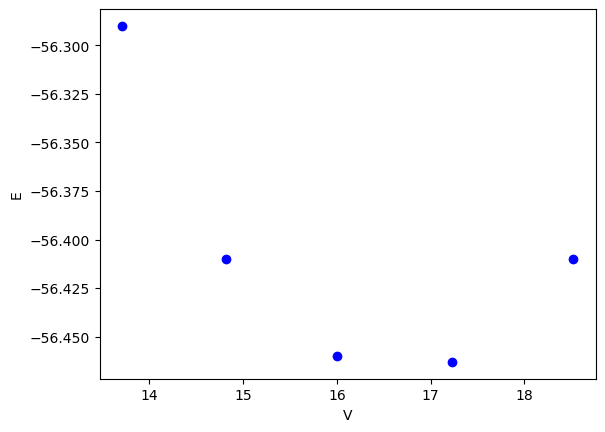

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import csv using a pandas dataframe!
df = pd.read_csv("review_optimization.csv")
volumes = df["volumes"].values
energies = df["energies"].values

plt.plot(volumes, energies, "bo")
plt.xlabel("V")
plt.ylabel("E")

In Materials Science we often want to fit an equation of state to this data. We will use this equation:

$E = E_0 + \frac{B_0 V}{B_0'}\left(\frac{(V_0 / V)^{B_0'}}{B_0' - 1} + 1 \right) - \frac{V_0 B_0}{B_0' - 1}$

from [https://journals.aps.org/prb/pdf/10.1103/PhysRevB.28.5480](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.28.5480). In this model there are four parameters:

| name|desc|
|---|---|
| E\_0|energy at the minimim|
| B\_0|bulk modulus|
| B\_0'|first derivative of the bulk modulus|
| V\_0|volume at the energy minimum|

We would like to find the value of these parameters that best fits the data above. That means, find the set of parameters that minimize the sum of the squared errors between the model and data.

First we need a function that will use the parameters and return the energy for a given volume.

In [18]:
def Murnaghan(parameters, vol):
    "From PRB 28,5480 (1983)"
    E0, B0, BP, V0 = parameters
    E = E0 + B0 * vol / BP * (((V0 / vol) ** BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E

Next, we need a function that computes the summed squared errors for a set of parameters. The use of squared errors is preferable in many cases to the absolute values because it has a continuous derivative. We will learn more about this later.

In [19]:
def objective(pars):
    err = energies - Murnaghan(pars, volumes)
    return np.sum(err**2)  # we return the summed squared error directly

Finally,  we need an initial guess to start the minimization. As with all minimization problems, this can be the most difficult step. It is always a good idea to use properties of the model and data where possible to make these guesses. We have no way to plot anything in four dimensions, so we use analysis instead.

We can derive some of these from the data we have. First, we can get the minimum in energy and the corresponding volume that we know from the data. These are not the final answer, but they are a good guess for it.

The B<sub>0</sub> parameter is related to the curvature at the minimum, which is the second derivative. We get that from repeated calls to `numpy.gradient`. Finally, $B_0'$ is related to the derivative of $B$ at the minimum, so we estimate that too.

In [20]:
imin = np.argmin(energies)
dedv = np.gradient(energies, volumes)
B = np.gradient(dedv, volumes)
Bp = np.gradient(B, volumes)


x0 = [energies[imin], B[imin], Bp[imin], volumes[imin]]

x0

[-56.463, 0.02575384116153356, -0.00900405886406903, 17.23]

Finally, we are ready to fit our function. As usual, we also plot the data and the fit for visual inspection.

      fun: 1.491342970068105e-05
 hess_inv: array([[ 3.15514620e-01, -3.20155406e+00,  7.74103643e+01,
        -1.97336028e+00],
       [-3.20155406e+00,  5.58406362e+01, -1.58550458e+03,
         3.96238529e+01],
       [ 7.74103643e+01, -1.58550458e+03,  6.54517772e+04,
        -2.47812337e+03],
       [-1.97336028e+00,  3.96238529e+01, -2.47812337e+03,
         1.39823769e+02]])
      jac: array([ 6.38314248e-06,  1.34489937e-07, -4.90979346e-08, -3.19168475e-06])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 31
     njev: 36
   status: 0
  success: True
        x: array([-56.46839132,   0.57225664,   2.74673677,  16.55866445])


Text(0, 0.5, 'E')

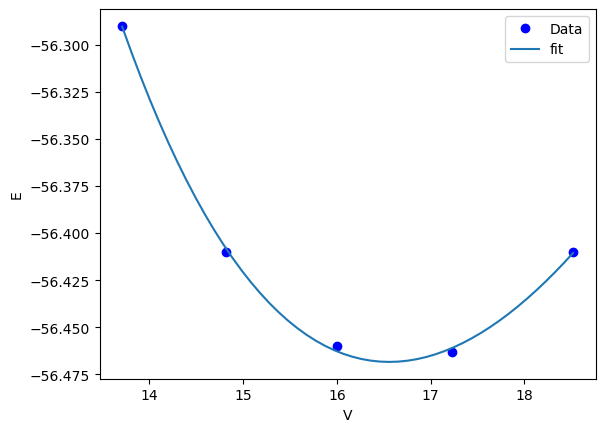

In [21]:
from scipy.optimize import minimize

sol = minimize(objective, x0)
print(sol)

plt.plot(volumes, energies, "bo", label="Data")
vfit = np.linspace(min(volumes), max(volumes))
plt.plot(vfit, Murnaghan(sol.x, vfit), label="fit")
plt.legend()
plt.xlabel("V")
plt.ylabel("E")

That looks pretty good. We should ask ourselves, how do we know we got a minimum? We should see that the objective function is really at a minimum *for each of the parameters*. Here, we show that it is a minimum for the first parameter.

Text(0, 0.5, 'summed squared error')

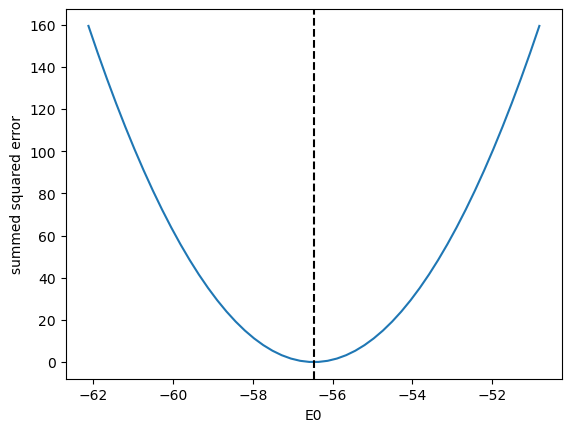

In [22]:
E0_range = np.linspace(0.9 * sol.x[0], 1.1 * sol.x[0])

errs = [objective([e0, *sol.x[1:]]) for e0 in E0_range]

plt.plot(E0_range, errs)
plt.axvline(sol.x[0], c="k", ls="--")
plt.xlabel("E0")
plt.ylabel("summed squared error")

## Parameter confidence intervals and curve fitting with `lmfit`

We have left out an important topic in the discussion above: How certain are we of the parameters we estimated? This is a complicated question that requires moderately sophisticated statistics to answer. We discussed how to do this at the end of 06-262, and we used a special python package `lmfit` to do so!

`lmfit` has some nice properties:
* It's easy to use
* It's general for non-linear curve fitting problems
* It handled various loss functions
* It handles the basic statistics of linear uncertainty analysis for you

`````{seealso}
https://lmfit.github.io/lmfit-py/
`````

[[Model]]
    Model(MurnaghanLmfit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 5
    # variables        = 4
    chi-square         = 1.4913e-05
    reduced chi-square = 1.4913e-05
    Akaike info crit   = -55.6135982
    Bayesian info crit = -57.1758466
[[Variables]]
    E0: -56.4683965 +/- 0.00303671 (0.01%) (init = -56.463)
    B0:  0.57233308 +/- 0.04018672 (7.02%) (init = 0.02575384)
    BP:  2.74075619 +/- 1.42020815 (51.82%) (init = -0.009004059)
    V0:  16.5590580 +/- 0.06876072 (0.42%) (init = 17.23)
[[Correlations]] (unreported correlations are < 0.100)
    C(BP, V0) = -0.832
    C(B0, BP) = -0.820
    C(E0, B0) = -0.773
    C(E0, BP) = 0.548
    C(B0, V0) = 0.451
    C(E0, V0) = -0.319


Text(0, 0.5, 'E')

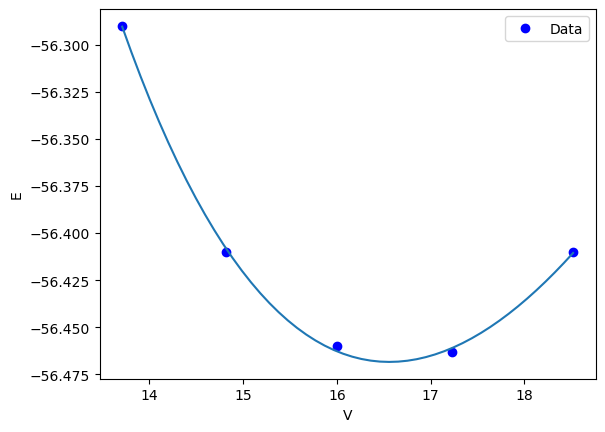

In [23]:
from lmfit import Model


def MurnaghanLmfit(vol, E0, B0, BP, V0):
    "From PRB 28,5480 (1983)"
    E = E0 + B0 * vol / BP * (((V0 / vol) ** BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E


gmodel = Model(
    MurnaghanLmfit, independent_vars=["vol"], param_names=["E0", "B0", "BP", "V0"]
)
params = gmodel.make_params(
    E0=energies[imin], B0=B[imin], BP=Bp[imin], V0=volumes[imin]
)

result = gmodel.fit(energies, params, vol=volumes)

print(result.fit_report())
vfit = np.linspace(min(volumes), max(volumes))

fitted_energies = result.eval(vol=vfit)


plt.plot(volumes, energies, "bo", label="Data")
plt.plot(vfit, fitted_energies)

plt.legend()
plt.xlabel("V")
plt.ylabel("E")

## Summary

Today we introduced the concept of finding minima/maxima in functions. This is an iterative process, much like finding the roots of a nonlinear function. You can think of it as finding the zeros of the derivative of a nonlinear function! This method is the root of many important optimization problems including regression.

`scipy.optimize.minimize` is the preferred function for doing minimization. There are other more specific ones described at [https://docs.scipy.org/doc/scipy/reference/optimize.html](https://docs.scipy.org/doc/scipy/reference/optimize.html), but `minimize` has a more consistent interface and provides almost all the functionality of those other methods. We also discussed how heuristic global optimization can be used to find function global minima.

We covered a lot of ground today. The key points are:
1.  Regression is a minimization of an accumulated error function.
2.  If you need uncertainty on the parameters from a regression, use `lmfit` or another package to handle the statistics, but think about the assumptions being made!
3.  If you need uncertainty on model predictions, you can either simulate it, or derive it. We will learn more about deriving it later in the context of machine learning models.